# Model comparison to GLODAP along GO-SHIP Easy Ocean lines
This notebook shows a means of comparing MOM6 ocean model data to GLODAP data along the WOCE/GO-SHIP sections. GLODAP data are taken from the cruises used to construct the Easy Ocean lines. Model data are interpolated onto the cruis station locations using `xesmf`. See [here](https://www.glodap.info/) for information on GLODAP, and [here](https://cchdo.ucsd.edu/products/goship-easyocean) for information on the Easy Ocean lines.

In [1]:
import pandas as pd
from cartopy import crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from xhistogram.xarray import histogram
import numpy as np
import gfdl_utils as gu
import glob
import re
from scipy.interpolate import griddata
import geopy
import cmocean
import gsw
from geopy import distance
import xesmf as xe
import sectionate
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/src')
import src
from src import *

In [2]:
plotsdir = lambda x="" : "../figures/" + x


In [3]:
def GLODAPP_LON_to_CM4X(lons):
    lons_copy = 1 * lons 
    lons_copy[lons_copy > 60] -= 360
    return lons_copy
def CM4X_LON_to_GLODAPP(lons): 
    lons_copy = 1 * lons 
    lons_copy[(lons_copy > -300) * (lons_copy < -180)] +=360
    return lons_copy

def CM4X_to_reg_grid(ds): 
    xhcopy = 1 * ds.xh.values
    xhcopy[(ds.xh > -300) * (ds.xh < -180)] += 360
    
    ds_copy = 1 * ds
    ds_copy.coords['xh'] = 1 * xhcopy

    return ds_copy.reindex({ "xh" : xhcopy})

def read_CM4X(fname): 
    return xr.open_mfdataset(
        fname,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        chunks={"latitude":-1, "longitude":-1},
        engine="zarr")

def compute_depth_average(ds, zmin, zmax): 
    return ds.sel(zl = slice(zmin, zmax)).mean("zl")

## Read GLODAP data

In [4]:
df = pd.read_csv('GLODAPv2.2023_Merged_Master_File.csv',na_values=9999)
df = df.replace(-9999, np.nan)

/tmp/ipykernel_89060/2969653573.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('GLODAPv2.2023_Merged_Master_File.csv',na_values=9999)


## Plot options
Specify a WOCE/GO-SHIP section line to look at, and a year range for the model.

In [41]:
line = 'A16-A23'
time = '1990-2014'

In [42]:
# GLODAP:model variable naming conventions
model2glodap_names = {'cfc12':'cfc12','cfc11':'cfc11','sf6':'sf6','thetao':'theta','so':'salinity'}
variable_kwargs = {
    'cfc12':{'conversion':1e12/1035,'cmap':'Greens','units':'pmolkg-1'},
    'cfc11':{'conversion':1e12/1035,'cmap':'PuRd','units':'pmolkg-1'},
    'sf6':{'conversion':1e12/1035 * 1e3,'cmap':'PuRd','units':'fmolkg-1'},
    'thetao':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'degK','bins':np.arange(-2,35,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'salinity':{'conversion':1,'cmap':cmocean.cm.haline,'units':'psu','bins':np.arange(32,37,0.05),'anombins':np.arange(-1,1.02,0.02)}
}

## Read GO-SHIP Easy Ocean data

In [43]:
rootdir = glob.glob('GO-SHIP/gridded/*/'+line)[0]
# Get merged netcdf file
filename = line.lower()+'.nc'
path = '/'.join([rootdir,filename])
dso_nc = xr.open_dataset(path)

## Match GLODAP data with cruises used for Easy Ocean
(via the `expocode`)

In [44]:
dfo = match_GLODAPP_WOCE(df, dso_nc, time)

Available cruise data : 33RO20130803 33RO20131223 74DI20110715


## Derive sections for each cruise, and corresponding model data

In [45]:
sections = extract_GLODAPP_cruises(dfo)
for (i, cruise) in enumerate(sections.keys()):
    sections[cruise] = get_thetao(sections[cruise])

## Plot section locations

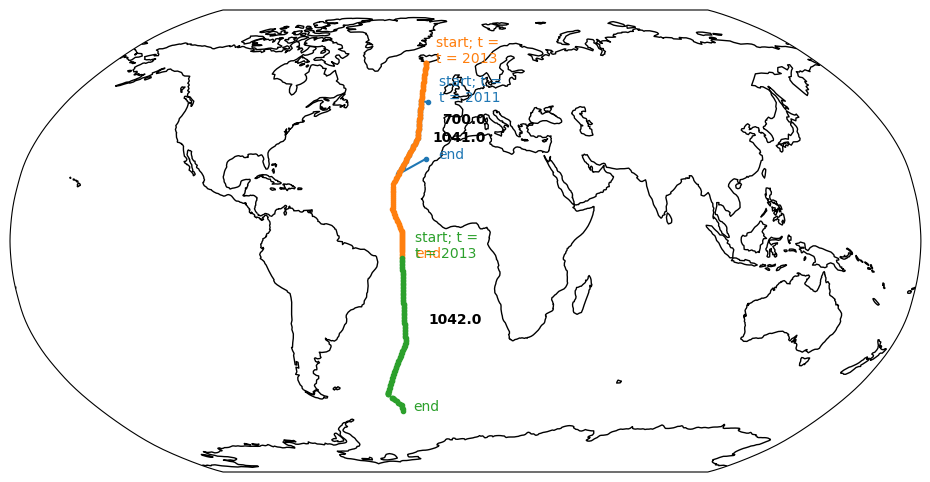

In [46]:
fig,ax=plt.subplots(figsize=(12,6),subplot_kw={'projection':ccrs.Robinson(central_longitude = 0)})
ax.set_global()
ax.coastlines()
for cruise,section in sections.items():
    x = CM4X_LON_to_GLODAPP(section['lon'])
    y = section['lat']
    l = ax.plot(x,y,transform=ccrs.PlateCarree(),marker='.')
    
    color = l[0].get_color()
    ax.text(x[int(len(x)/2)]+10,y[int(len(y)/2)] + 5,str(cruise) ,transform=ccrs.PlateCarree(),color="k",fontweight='bold',horizontalalignment='left')
    ax.text(x[0]+5,y[0],'start; t = '+ "\nt = " + str(int(section.time.values)),transform=ccrs.PlateCarree(),color=color,horizontalalignment='left')
    ax.text(x[-1]+5,y[-1],'end',transform=ccrs.PlateCarree(),color=color,horizontalalignment='left')

fig.savefig(plotsdir(line + "_MAP.png"), dpi = 400, bbox_inches = "tight")


In [47]:
cruise_times = np.array([int(s.time.values) for s in sections.values()])

## Plot load CM4X data

In [48]:
ds = read_CM4X("../../CM4Xp25_historical_transient_tracers.zarr")
ds = ds.sel(year = slice(cruise_times.min(), cruise_times.max())).mean("year")

ds["z"] = ds["z"].transpose("zl", "yh", "xh")
ds["thkcello"] = ds["thkcello"].transpose("zl", "yh", "xh")

ds = ds.drop(["lat", "lon"])
ds = ds.rename({"geolat":"lat", "geolon":"lon"})
ds = get_sigma2(ds)

In [49]:
sections_dsm = {}
for cruise, section in sections.items():
    regridder = xe.Regridder(ds, sections[cruise][["lon", "lat"]], "bilinear", locstream_out=True)
    section_dsm = regridder(ds)

    print("Cruise #: ", cruise)

    # Apply conversion
    for key,value in variable_kwargs.items():
        if key in section_dsm.keys():
            print(key)
            section_dsm[key] = section_dsm[key]*variable_kwargs[key]['conversion']
    # section_dsm = section_dsm.where(section_dsm.thkcello > 1e-10)
    sections_dsm[cruise] = 1 * section_dsm

Cruise #:  700.0
cfc12
cfc11
sf6
thetao
Cruise #:  1041.0
cfc12
cfc11
sf6
thetao
Cruise #:  1042.0
cfc12
cfc11
sf6
thetao


In [50]:
new_z_grid = -1 * np.concatenate((np.linspace(0.1, 3000, 30), np.linspace(3025, 4000, 41), np.linspace(4000, 6000, 4)))

In [51]:
sections_dsmo = {}
for cruise,section_dsm in sections_dsm.items():
    # section_dsmo = section_dsm.drop(['zl'])
    # section_dsmo['depth']=section['depth']
    sections_tmp = 1 * sections_dsm[cruise]
    sections_tmp = sections_tmp.where(sections_tmp.thkcello > 1e-9)
    sections_dsmo[cruise] = 1 * interpolate_section(sections_tmp.compute(), new_z_grid, 
                    interp_coord = "z",iterate_coord =  "distance", kind = "linear")

cfc11
cfc12
sf6
so
thetao
thkcello
sigma2
cfc11
cfc12
sf6
so
thetao
thkcello
sigma2
cfc11
cfc12
sf6
so
thetao
thkcello
sigma2


### plotting functions

In [53]:
def save_section_fig(fig, product, section, variable):
    fig.savefig(plotsdir(product + "_" + section + "_" + variable + ".png"), dpi = 400, bbox_inches = "tight")


## Plot sections of temperature

/tmp/ipykernel_89060/345036652.py:32: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(X,Y, Z, cmap=cmap, vmin = -0.8, vmax = 10)


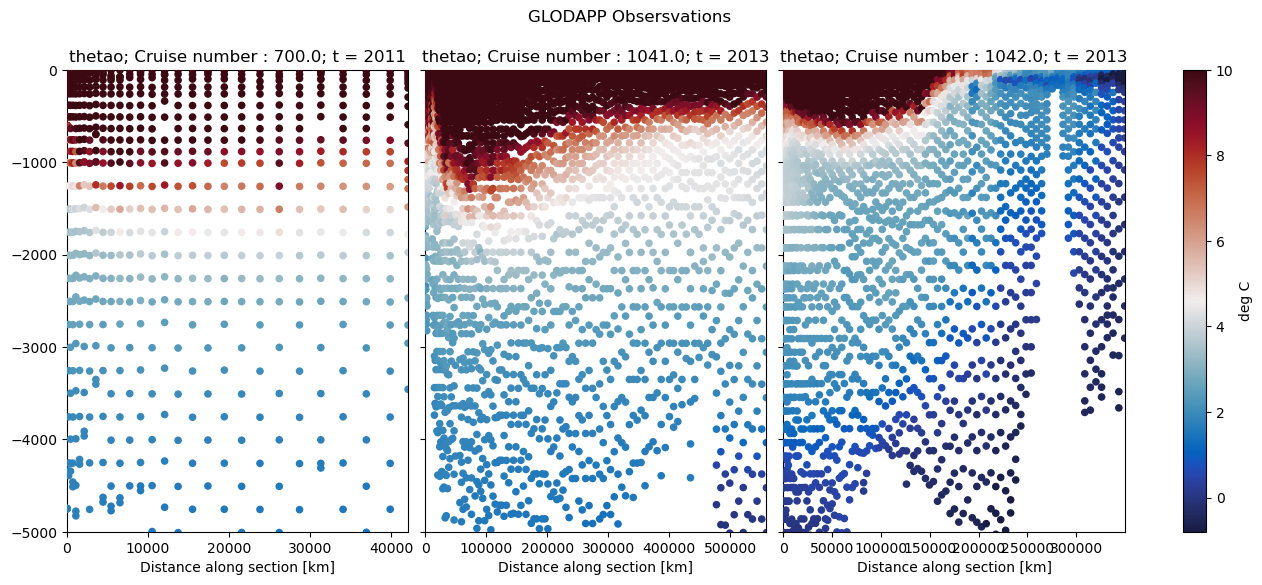

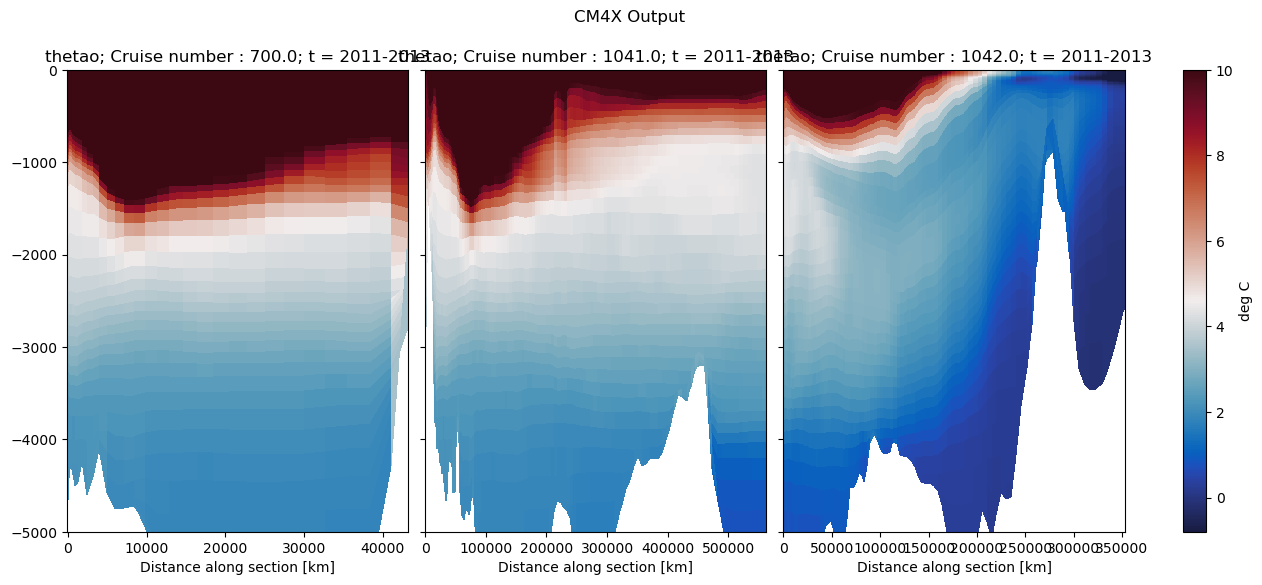

In [57]:
variable = 'thetao'
cmap = cmocean.cm.balance
units = "°C"
fig,axes = plt.subplots(1, 3, figsize=(15,6), sharey = True)
for (i, cruise) in enumerate(sections.keys()):
    ax = axes[i]
    X, _ = np.meshgrid(sections[cruise].distance, sections[cruise].n)
    Z = sections[cruise][variable].values
    Z[np.abs(Z) > 100] = np.nan
    Y = 1 * sections[cruise].z.values; Y[np.isnan(Y)] = 10
    im2 = ax.scatter(X.T.flatten(), Y.flatten(),c = Z.flatten() ,s=20, cmap=cmap,zorder=10, vmin = -0.8, vmax = 10)
    ax.set_xlabel('Distance along section [km]')
    t = np.int32(sections[cruise].time.values); t = str(t)
    ax.set_title(variable+'; Cruise number : '+str(cruise) + "; t = " + t)
    ax.set_ylim(-5000, 0)
    ax.set_xlim(sections[cruise].distance.min(), sections[cruise].distance.max())


fig.subplots_adjust(wspace = 0.05)
fig.suptitle("GLODAPP Obsersvations")
fig.colorbar(im2, ax = axes, label = "deg C", orientation = "vertical", fraction = 0.04)

save_section_fig(fig, "GLODAP", line, variable)

fig,axes = plt.subplots(1, 3, figsize=(15,6), sharey = True)
for (i, cruise) in enumerate(sections.keys()):
    ax = axes[i]
    X, _ = np.meshgrid(sections_dsm[cruise].distance, sections_dsm[cruise].zl)
    Z = sections_dsm[cruise][variable].values
    Y = 1 * sections_dsm[cruise].z.values; Y[np.isnan(Y)] = -6000
    Z[Z == 0.0] = np.nan
    im = ax.pcolormesh(X,Y, Z, cmap=cmap, vmin = -0.8, vmax = 10)
    ax.set_xlabel('Distance along section [km]')
    ax.set_title(variable+'; Cruise number : '+str(cruise) + "; t = " + str(cruise_times.min()) + "-" + str(cruise_times.max()) )
    ax.set_ylim(-5000, 0)

fig.subplots_adjust(wspace = 0.05)
fig.suptitle("CM4X Output")
fig.colorbar(im2, ax = axes, label = "deg C", orientation = "vertical", fraction = 0.04)
save_section_fig(fig, "CM4X", line, variable)

## Plot sections of CFC12

In [ ]:
variable = 'cfc12'
cmap = variable_kwargs[variable]['cmap']
units = variable_kwargs[variable]['units']
fig,axes = plt.subplots(1, 3, figsize=(15,6), sharey = True)
for (i, cruise) in enumerate(sections.keys()):
    ax = axes[i]
    X, _ = np.meshgrid(sections[cruise].distance, sections[cruise].n)
    Z = sections[cruise][variable].values; Z[np.isnan(Y)] = 1
    Y = 1 * sections[cruise].z.values; Y[np.isnan(Y)] = 10
    im2 = ax.scatter(X.T.flatten(), Y.flatten(),c = Z.flatten() ,s=50, cmap=cmap,zorder=10, 
                     vmin = 0, vmax = 1)
    ax.set_xlabel('Distance along section [km]')
    t = np.int32(sections[cruise].time.values); t = str(t)
    ax.set_title(variable+'; Cruise number : '+str(cruise) + "; t = " + t)
    ax.set_ylim(-5000, 0)
    ax.set_xlim(sections[cruise].distance.min(), sections[cruise].distance.max())

fig.subplots_adjust(wspace = 0.05)
fig.suptitle("GLODAP Obsersvations")
fig.colorbar(im2, ax = axes, label = units, orientation = "vertical", fraction = 0.04)

save_section_fig(fig, "GLODAP", line, variable)

/tmp/ipykernel_89060/2440907159.py:9: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(X,Y, Z, cmap=cmap, vmin = 0, vmax = 1)
/tmp/ipykernel_89060/2440907159.py:9: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(X,Y, Z, cmap=cmap, vmin = 0, vmax = 1)
/tmp/ipykernel_89060/2440907159.py:9: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolor

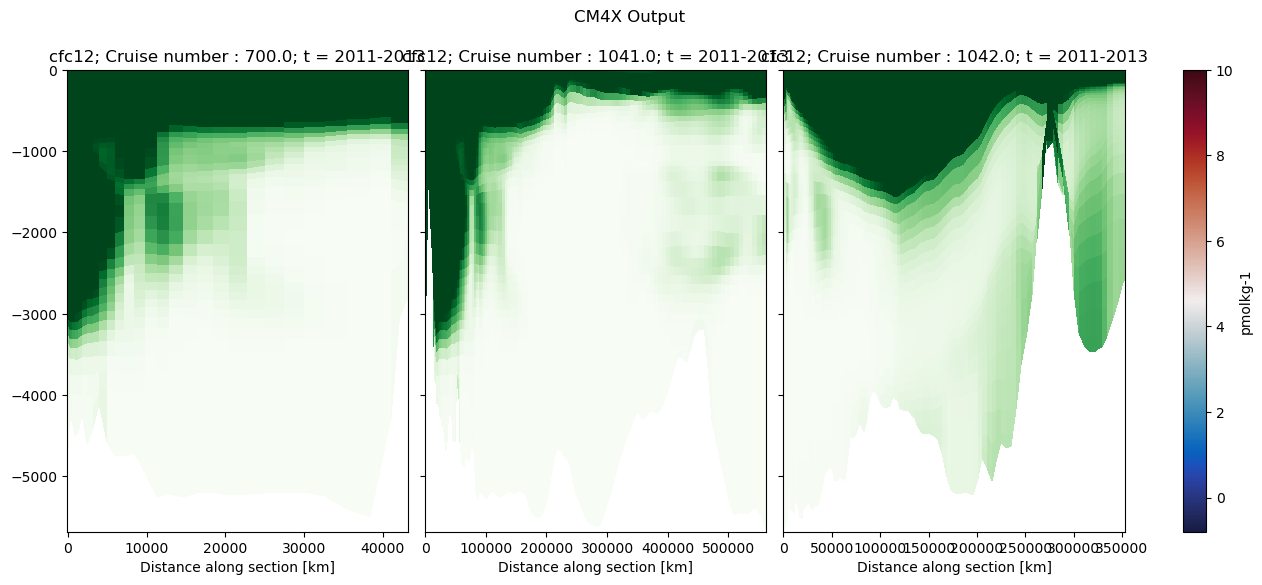

In [68]:
fig,axes = plt.subplots(1, 3, figsize=(15,6), sharey = True)
for (i, cruise) in enumerate(sections.keys()):
    ax = axes[i]
    sections_tmp = 1 * sections_dsm[cruise]
    # sections_tmp = sections_tmp.where(sections_tmp.thkcello > 1e-9)
    X, _ = np.meshgrid(sections_tmp.distance, sections_tmp.zl)
    Z = sections_tmp[variable].values
    Y = 1 * sections_tmp.z.values;
    im = ax.pcolormesh(X,Y, Z, cmap=cmap, vmin = 0, vmax = 1)
    ax.set_xlabel('Distance along section [km]')
    ax.set_title(variable+'; Cruise number : '+str(cruise) + "; t = " + str(cruise_times.min()) + "-" + str(cruise_times.max()) )
    # fig.colorbar(im2, ax = ax, label = "pmol/kg", orientation = "vertical", fraction = 0.04)

fig.subplots_adjust(wspace = 0.05)
fig.suptitle("CM4X Output")
fig.colorbar(im2, ax = axes, label = units, orientation = "vertical", fraction = 0.04)

save_section_fig(fig, "CM4X", line, variable)

/tmp/ipykernel_88353/1598954804.py:30: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(X,Y, Z, cmap=cmap, vmin = 0, vmax = 1)


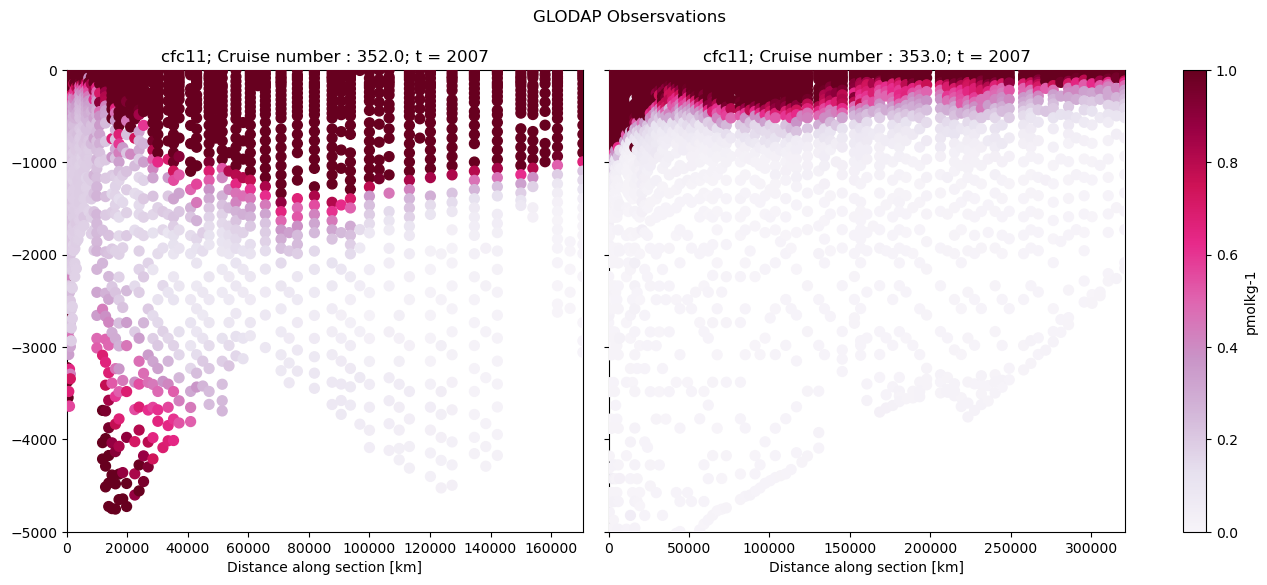

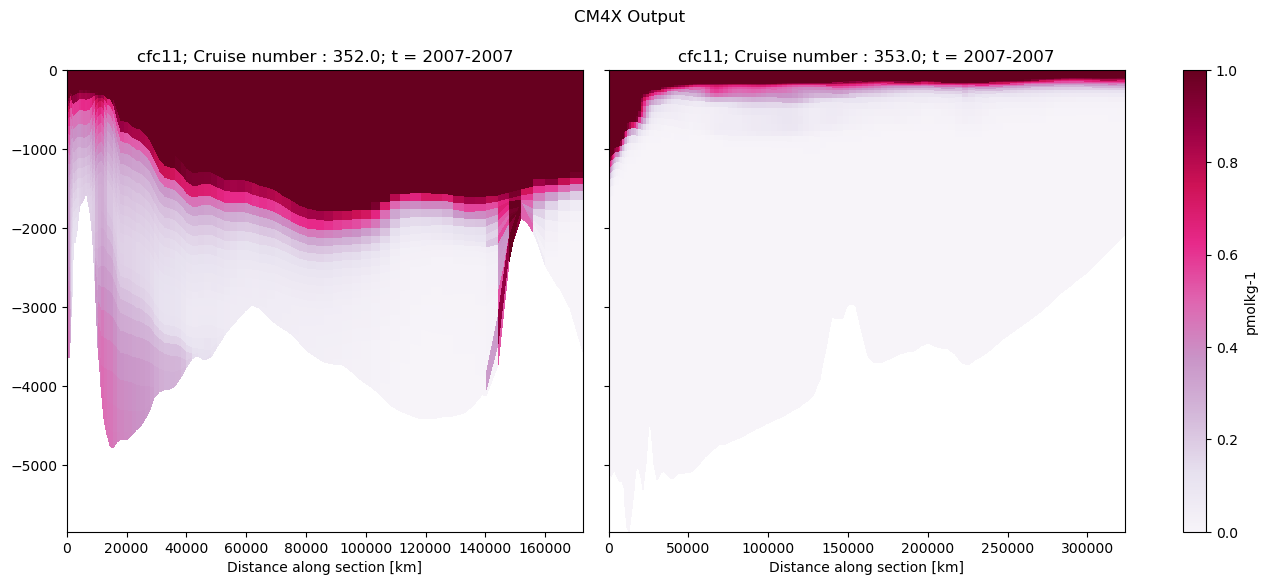

In [43]:
variable = 'cfc11'
cmap = variable_kwargs[variable]['cmap']
units = variable_kwargs[variable]['units']
fig,axes = plt.subplots(1, 2, figsize=(15,6), sharey = True)
for (i, cruise) in enumerate(sections.keys()):
    ax = axes[i]
    X, _ = np.meshgrid(sections[cruise].distance, sections[cruise].n)
    Z = sections[cruise][variable].values
    Y = 1 * sections[cruise].z.values; Y[np.isnan(Y)] = 10
    im2 = ax.scatter(X.T.flatten(), Y.flatten(),c = Z.flatten() ,s=50, cmap=cmap,zorder=10, 
                     vmin = 0, vmax = 1)
    ax.set_xlabel('Distance along section [km]')
    t = np.int32(sections[cruise].time.values); t = str(t)
    ax.set_title(variable+'; Cruise number : '+str(cruise) + "; t = " + t)
    ax.set_ylim(-5000, 0)
    ax.set_xlim(sections[cruise].distance.min(), sections[cruise].distance.max())

fig.subplots_adjust(wspace = 0.05)
fig.suptitle("GLODAP Obsersvations")
fig.colorbar(im2, ax = axes, label = units, orientation = "vertical", fraction = 0.04)

save_section_fig(fig, "GLODAP", line, variable)

fig,axes = plt.subplots(1, 2, figsize=(15,6), sharey = True)
for (i, cruise) in enumerate(sections.keys()):
    ax = axes[i]
    X, _ = np.meshgrid(sections_dsm[cruise].distance, sections_dsm[cruise].zl)
    Z = sections_dsm[cruise][variable].values
    Y = 1 * sections_dsm[cruise].z.values; Y[np.isnan(Y)] = 10
    im = ax.pcolormesh(X,Y, Z, cmap=cmap, vmin = 0, vmax = 1)
    ax.set_xlabel('Distance along section [km]')
    ax.set_title(variable+'; Cruise number : '+str(cruise) + "; t = " + str(cruise_times.min()) + "-" + str(cruise_times.max()) )

fig.subplots_adjust(wspace = 0.05)
fig.suptitle("CM4X Output")
fig.colorbar(im2, ax = axes, label = units, orientation = "vertical", fraction = 0.04)

save_section_fig(fig, "CM4X", line, variable)

StopIteration: 

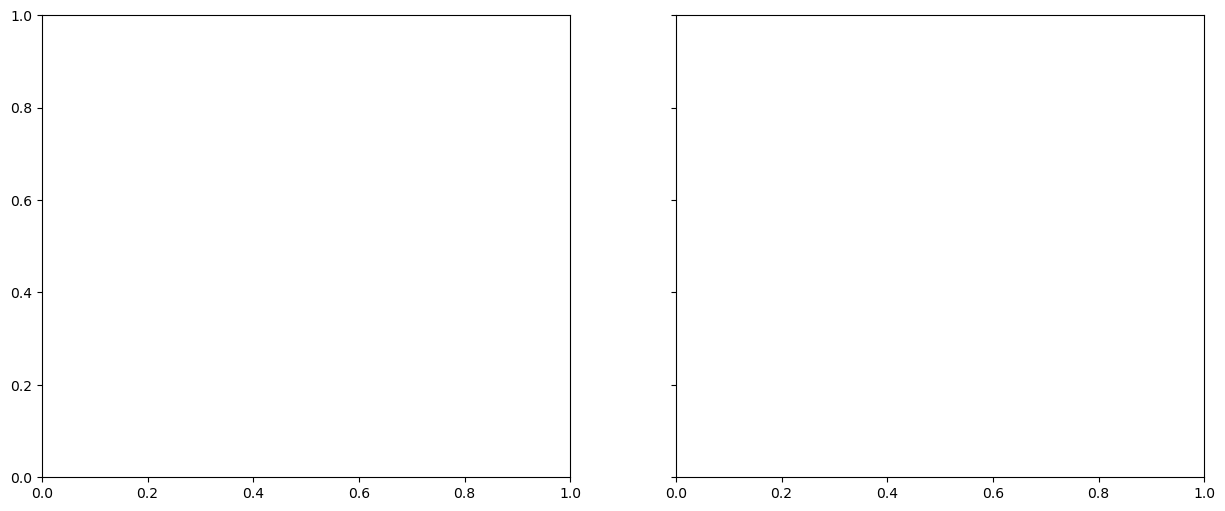

In [39]:
variable = 'sf6'
cmap = variable_kwargs[variable]['cmap']
units = variable_kwargs[variable]['units']
fig,axes = plt.subplots(1, 2, figsize=(15,6), sharey = True)
for (i, cruise) in enumerate(sections.keys()):
    ax = axes[i]
    X, _ = np.meshgrid(sections[cruise].distance, sections[cruise].n)
    Z = sections[cruise][variable].values
    Y = 1 * sections[cruise].z.values; Y[np.isnan(Y)] = 10
    im2 = ax.scatter(X.T.flatten(), Y.flatten(),c = Z.flatten() ,s=50, cmap=cmap,zorder=10, vmin = 0, vmax = 0.01)
    ax.set_xlabel('Distance along section [km]')
    t = np.int32(sections[cruise].time.values); t = str(t)
    ax.set_title(variable+'; Cruise number : '+str(cruise) + "; t = " + t)
    ax.set_ylim(-5000, 0)
    ax.set_xlim(sections[cruise].distance.min(), sections[cruise].distance.max())

fig.subplots_adjust(wspace = 0.05)
fig.suptitle("GLODAP Obsersvations")
fig.colorbar(im2, ax = axes, label = units, orientation = "vertical", fraction = 0.04)

save_section_fig(fig, "GLODAP", line, variable)

/tmp/ipykernel_88353/2472934769.py:7: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(X,Y, Z, cmap=cmap, vmin = 0, vmax = 0.1)


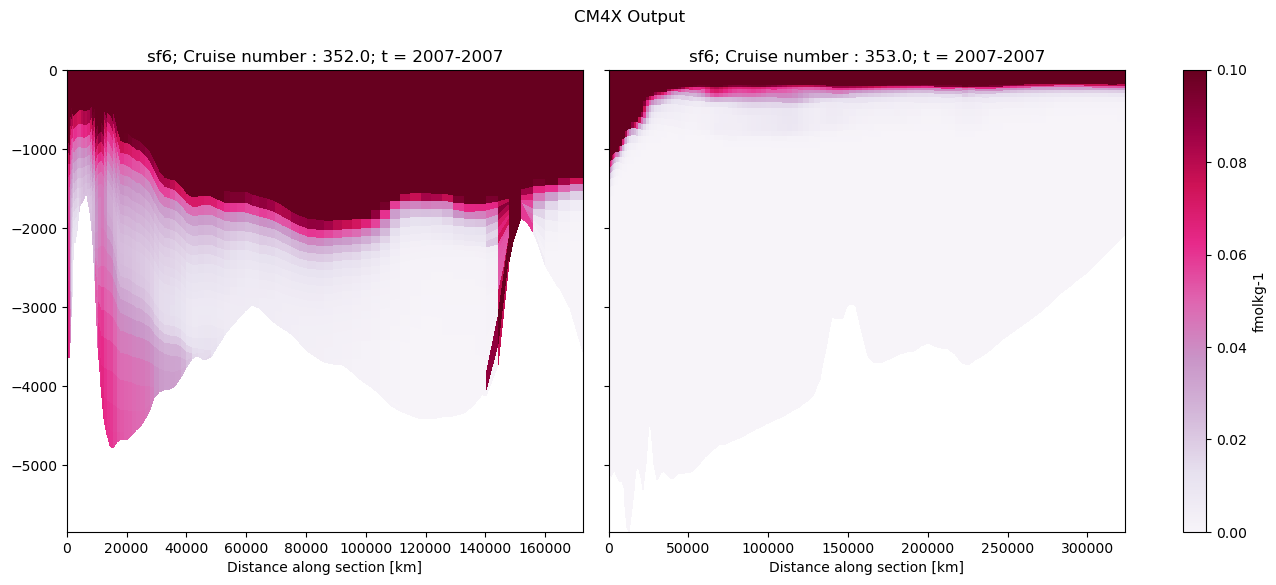

In [42]:
fig,axes = plt.subplots(1, 2, figsize=(15,6), sharey = True)
for (i, cruise) in enumerate(sections.keys()):
    ax = axes[i]
    X, _ = np.meshgrid(sections_dsm[cruise].distance, sections_dsm[cruise].zl)
    Z = sections_dsm[cruise][variable].values
    Y = 1 * sections_dsm[cruise].z.values; Y[np.isnan(Y)] = 10
    im = ax.pcolormesh(X,Y, Z, cmap=cmap, vmin = 0, vmax = 0.1)
    ax.set_xlabel('Distance along section [km]')
    ax.set_title(variable+'; Cruise number : '+str(cruise) + "; t = " + str(cruise_times.min()) + "-" + str(cruise_times.max()) )

fig.subplots_adjust(wspace = 0.05)
fig.suptitle("CM4X Output")
fig.colorbar(im2, ax = axes, label = units, orientation = "vertical", fraction = 0.04)
save_section_fig(fig, "CM4X", line, variable)